In [1]:
import numpy as np
from matplotlib import colors
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import pickle
import signac as sg
from scipy.special import gamma
import copy as copy
import scipy
from global_functions import adjustmaps, lambda_s
import h5py
from scipy.interpolate import make_lsq_spline
from itertools import product

In [2]:
# Update global plotting parameters
rc('axes', labelsize=16)  # Font size for x and y labels
rc('axes', titlesize=16)
rc('xtick', labelsize=15)  # Font size for x-axis tick labels
rc('ytick', labelsize=15)  # Font size for y-axis tick labels
rc('lines', markersize=12)  # Set the default marker size to 10 points
rc('legend', fontsize=14)

# Define/load things non-specific to a given set of results
project = sg.get_project()
# metric = "P_s"
metric = "lambda_s"
# metric = 's'
Aeff = 7.29
t_final = 300
ncell_tot = 87_993
c = 1.42
tauc_methods = ["flat"]
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
tau_vec = b_vec * gamma(1+1/c)
# tau_step = np.diff(tau_vec)[0] / 2
# tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
# tau_step = np.diff(tau_vec)[1] / 2
# tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
tau_diffs = np.diff(tau_vec)
tau_step = tau_diffs[1]
tau_edges = np.concatenate((
                [tau_vec[0]],
                [tau_diffs[0]/2],
                np.arange(tau_vec[1]+tau_step/2, tau_vec[-1]+tau_step, tau_step)
                           ))

def set_globals(results_pre):
    if results_pre == 'meta_mean_results':
        globals()['metric_lab'] = f'$<{metric}>_{{meta}}$'
    else:
        globals()['metric_lab'] = f'$P(<{metric}>_k \geq 0.5)$'
    globals()['fn_prefix'] = f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    globals()['fig_prefix'] = f"{results_pre}/figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"

    # Load things saved specific to these results
    with open(fn_prefix + 'metric_data.pkl', 'rb') as handle:
        globals()['metric_data'] = pickle.load(handle)
    globals()['all_metric'] = metric_data['all_metric']
    globals()['all_tau'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/all_tau.npy")
    globals()['C_vec'] = np.load(fn_prefix + "C_vec.npy")
    globals()['ncell_vec'] = np.load(fn_prefix + "ncell_vec.npy")
    globals()['slice_left_all'] = np.load(fn_prefix + "slice_left_all.npy")
    eps_axes = {}
    with h5py.File(fn_prefix + "/eps_axes.h5", "r") as handle:
        for key in handle.keys():
            eps_axes.update({key: handle[key][()]})
    globals()['eps_axes'] = eps_axes

### Testing

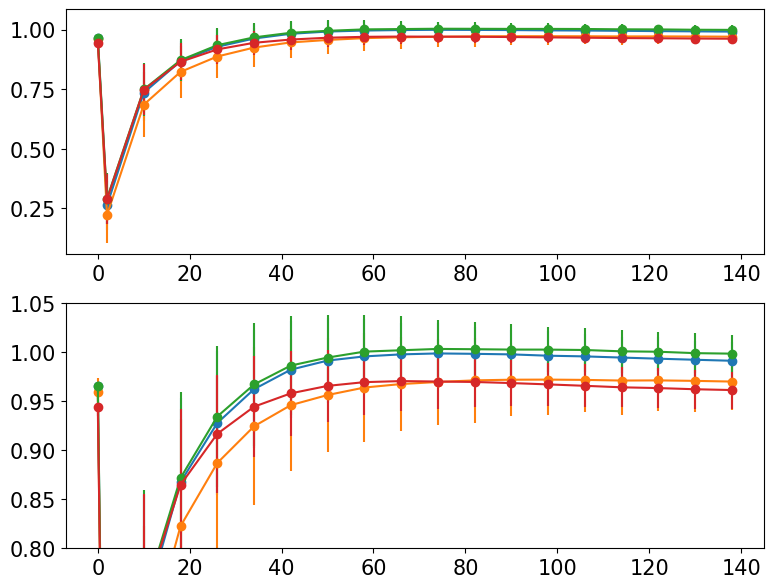

In [36]:
fig, axes = plt.subplots(2, figsize=(9,7))
for job_i, job in enumerate(project):
    if (job_i < 9) or (job_i > 12): 
        continue
    lams = []
    lam_stds = []
    with job.data:
        for b in b_vec:
            lams.append(float(job.data[f'lambda_s/{b}']))
            lam_stds.append(float(job.data[f'lambda_s_std/{b}']))
    for i in range(len(axes)):
        axes[i].errorbar(b_vec, lams, yerr=lam_stds, marker='o', markersize=6)
    axes[1].set_ylim(0.8, 1.05)
    # break

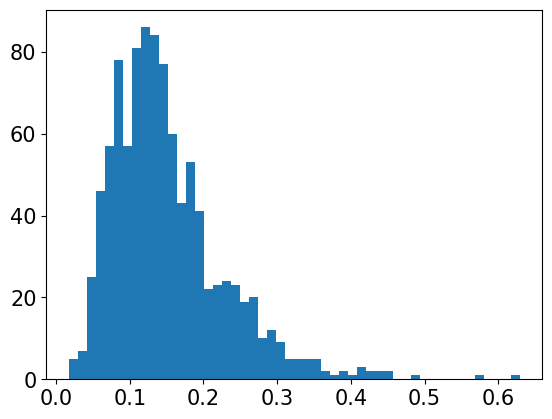

In [58]:
import torch
lognorm_draws = torch.empty(1000).log_normal_(-2, 0.5)
plt.hist(lognorm_draws, bins=50);

Text(0.5, 0, 'x')

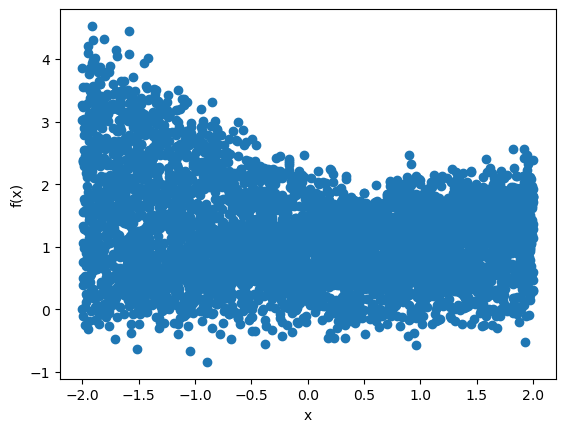

In [4]:
# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture via Bayesian layers
    # std = torch.where(x[:,0] >= 0, torch.sqrt(x[:,0]), 0.001)
    std = 0.3
    # std = torch.sqrt(torch.abs(x[:,0]))
    # std = torch.where(x[:,0] < 0, 0, std)
    # std_slope = 0.3
    # std = torch.abs(x[:,0])*std_slope
    # mu = torch.ones(x.shape[0]) * -0.3
    # mu = torch.where(x[:,0] < 0.3, mu, -mu)
    # mu = torch.square(x[:,0])
    # mu_slope = 0.05
    # mu = (x[:,0]-2)*mu_slope
    mu = torch.zeros(x.shape[0])
    extra_noise = torch.normal(mean=mu, std=std)
    # extra_noise = torch.where(extra_noise < 0, 0, extra_noise)
    # extra_noise = torch.empty_like(noised_value).uniform_(-0.1, 0.1)
    # extra_noise = torch.empty_like(noised_value).log_normal_(0, 0.1)
    return noised_value + extra_noise
train_x = torch.empty(5_000, 2)
train_x[:,0].uniform_(-2,2)
train_x[:,1].uniform_(-EPS, EPS)
train_y  = expensive_function(train_x)
plt.scatter(train_x[:,0], train_y)
plt.ylabel('f(x)')
plt.xlabel('x')
# plt.ylim(1.75,2.5)

Epoch 0: ELBO Loss = 1.7761
Epoch 200: ELBO Loss = 0.1269
Epoch 400: ELBO Loss = 0.0340
Epoch 600: ELBO Loss = 0.0217
Epoch 800: ELBO Loss = 0.0173
Epoch 1000: ELBO Loss = 0.0140
Epoch 1200: ELBO Loss = 0.0127
Epoch 1400: ELBO Loss = 0.0100
Epoch 1600: ELBO Loss = 0.0085
Epoch 1800: ELBO Loss = 0.0075
mean candidate: 0.47431063652038574, std: 0.08216358721256256


/Users/patrick/Research/Regan/TecateCypress/sensitivity/opttest_3_bayesian_2.py:73: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = outputs.std(dim=0)


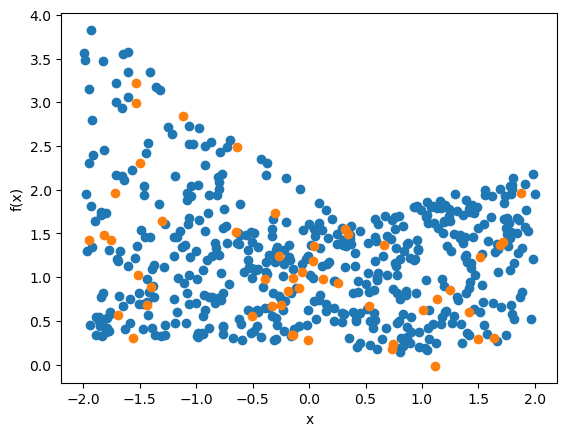

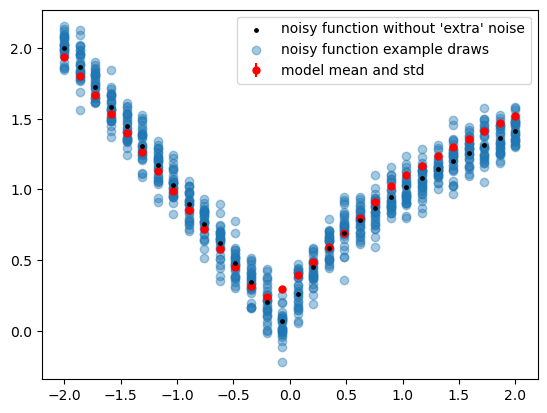

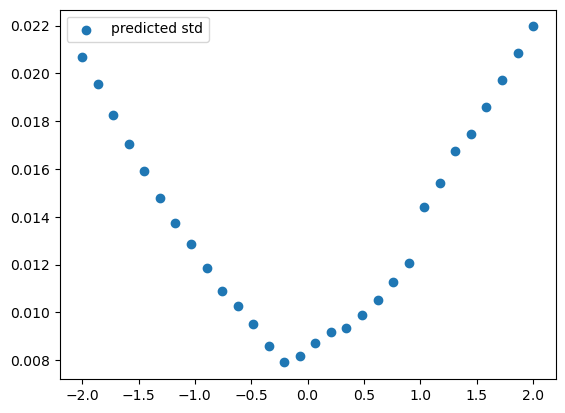

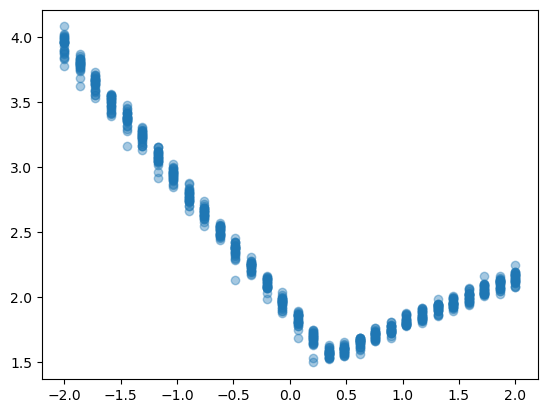

In [1]:
# from opttest_3_bayesian import *
# from opttest_3_bayesian_1 import *
from opttest_3_bayesian_2 import *
# from opttest_mcdropout import *
# from opttest_3_deterministic import *
# from opttest_3_gaussian import *

test_i = 3
train_x = torch.load(f'train_x_{test_i}', weights_only=True)
train_y = torch.load(f'train_y_{test_i}', weights_only=True)
plt.scatter(train_x[:,0], train_y)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()

def function_without_extra_noise(x):
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    return noised_value 

x_repeats = 30
train_x = torch.empty(30, 2)
# train_x[:,0].uniform_(-2,2)
train_x[:,0] = torch.linspace(-2,2,train_x.shape[0])
# train_x[:,1].uniform_(-EPS, EPS)
train_x[:,1] = torch.zeros(train_x.shape[0]) 

with torch.no_grad():
    # Bayesian / deterministic
    mu_pred_all = torch.stack([model(train_x) for _ in range(x_repeats)])
    mu_pred = mu_pred_all.mean(axis=0).squeeze()
    std = mu_pred_all.std(axis=0).squeeze()
    
    # Bayesian_1
    # mu_pred, std = model(train_x)
    # mu_pred = mu_pred.squeeze()
    # std = std.squeeze()
    
    # Gaussian / mcdropout
    # mu_pred, var_pred = model(train_x)
    # mu_pred = mu_pred.squeeze()
    # std = torch.sqrt(var_pred.squeeze())
    
    plt.errorbar(train_x[:,0], mu_pred, yerr=std, c='r', fmt='o', markersize=5, label='model mean and std', zorder=1)
    
    plt.scatter(train_x[:,0], function_without_extra_noise(train_x), c='k', label="noisy function without 'extra' noise", alpha=1, s=6, zorder=2)
    train_x = train_x.repeat((x_repeats,1)) 
    train_y  = expensive_function(train_x)
    plt.scatter(train_x[:,0], train_y, label='noisy function example draws', alpha=0.4)
    plt.legend()
    plt.show()
    
    plt.scatter(torch.unique(train_x[:, 0]), std, label='predicted std')
    plt.legend()
    plt.show()

robust_samples = model.posterior_robust(train_x[:,0], num_eps_samples=100, eps=2).squeeze(1).detach()
plt.scatter(train_x[:,0], robust_samples, alpha=0.4)
# x_reduced = torch.unique(train_x[:,0])
# robust_samples = model.posterior_robust(x_reduced, num_eps_samples=500, eps=2).squeeze(1).detach()
# plt.scatter(x_reduced, robust_samples)
plt.show()

In [1]:
def function_without_extra_noise(x):
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    return noised_value 

x_repeats = 30
train_x = torch.empty(30, 2)
# train_x[:,0].uniform_(-2,2)
train_x[:,0] = torch.linspace(-2,2,train_x.shape[0])
# train_x[:,1].uniform_(-EPS, EPS)
train_x[:,1] = torch.zeros(train_x.shape[0]) 

with torch.no_grad():
    # Bayesian / deterministic
    # mu_pred_all = torch.stack([model(train_x) for _ in range(x_repeats)])
    # mu_pred = mu_pred_all.mean(axis=0).squeeze()
    # std = mu_pred_all.std(axis=0).squeeze()
    
    # Gaussian
    mu_pred, var_pred = model(train_x)
    mu_pred = mu_pred.squeeze()
    std = torch.sqrt(var_pred.squeeze())
    
    plt.errorbar(train_x[:,0], mu_pred, yerr=std, c='r', fmt='o', markersize=5, label='model mean and std', zorder=1)
    
    plt.scatter(train_x[:,0], function_without_extra_noise(train_x), c='k', label="noisy function without 'extra' noise", alpha=1, s=6, zorder=2)
    train_x = train_x.repeat((x_repeats,1)) 
    train_y  = expensive_function(train_x)
    plt.scatter(train_x[:,0], train_y, label='noisy function example draws', alpha=0.4)
    plt.legend()
    plt.show()
    
    plt.scatter(torch.unique(train_x[:, 0]), std, label='predicted std')
    plt.legend()
    plt.show()

robust_samples = model.posterior_robust(train_x[:,0], num_eps_samples=500, eps=2).squeeze(1).detach()
plt.scatter(train_x[:,0], robust_samples)
plt.show()

NameError: name 'torch' is not defined

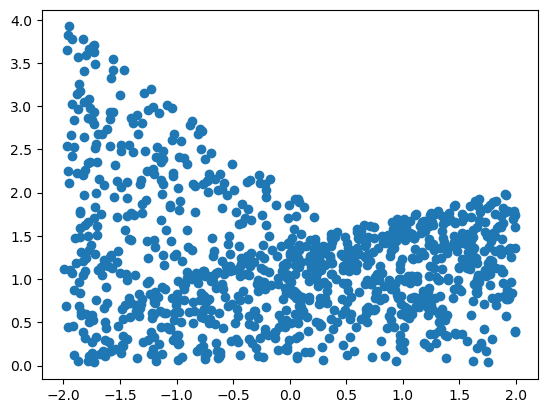

In [7]:
test_x = torch.empty(1000, 2)
test_x[:,0].uniform_(-2,2)
test_x[:,1].uniform_(-2, 2);
# mean, logvar = model(train_x)
mean, std = model.posterior(test_x)
# mean = model(test_x)
mean = mean.squeeze(1).detach()
plt.scatter(test_x[:,0], mean)
# std = torch.exp(logvar).sqrt()
# plt.hist(std.squeeze(1).detach());

In [ ]:
N_tot = np.load('test_data/N_tot_disc.npy')
N_tot_mean = np.mean(N_tot, axis=0)
for rep in N_tot[::100, :]:
    plt.plot(rep)
plt.plot(N_tot_mean, c='k', lw=6)
plt.plot(np.median(N_tot, axis=0), c='orange', lw=6)
# plt.ylim(0, 1e6)
plt.ylim(0, 50_000)
# plt.ylim(0, 1000)
# plt.xlim(0, 10)

In [ ]:
lam_all = lambda_s(N_tot, compressed=False)
print(np.mean(lam_all))
# print(np.mean(lambda_s(N_tot[:, :-4900], compressed=False)))

In [ ]:
results_pre = 'gte_thresh'
set_globals(results_pre)
project = sg.get_project()
jobs = project.find_jobs({'doc.simulated': True})
b_samples = [66]
for b in b_samples:
    for job_i, job in enumerate(jobs):
        with job.data as data:
            N_tot = np.array(data[f'N_tot/{b}'])
            census_t = np.array(data['census_t'])

        # for rep in N_tot[::10]:
        #     plt.plot(census_t, rep, alpha=0.1)
        # # plt.ylim(0, job.sp.params.K_adult*10)
        # plt.ylim(0, job.sp.params.K_adult*1000)

        valid_mask = N_tot > 0
        valid_timesteps = np.sum(valid_mask, axis=1) - 1
        final_N = np.take_along_axis(N_tot, valid_timesteps[..., None], axis=1)[:, 0]
        
        bin_join = job.sp.params.K_adult
        bins1 = np.arange(0, bin_join, job.sp.params.K_adult/100)
        bins2 = np.arange(bin_join, job.sp.params.K_adult*10, job.sp.params.K_adult)
        bins = np.concatenate((bins1, bins2, [job.sp.params.K_adult*1e3]))
        plt.hist(final_N, bins=bins)
        plt.xscale('log')
        plt.xlim(0, 100)
        break

In [ ]:
# Nf_rng = np.arange(0.1, 1.1, 0.05)
Nf_rng = np.arange(1, job.sp.params.K_adult+21, 20)
T_rng = np.arange(30, 330, 15)
# T_rng = np.arange(10, 130, 10)

Nf, T = np.meshgrid(Nf_rng, T_rng)
lam = (Nf / job.sp.params.K_adult) ** (1/T)

plt.pcolormesh(Nf, T, lam, shading='auto', cmap='viridis', vmin=0.68, vmax=1) 
plt.colorbar()
plt.xlabel('Nf')
plt.ylabel('T')

In [ ]:
fig, ax = plt.subplots(1, figsize=(6,5))
# Nf_rng = np.arange(0.01, 1.1, 0.005)
step = 0.001
Nf_rng = np.arange(step, 1+step, step)
# Nf_rng = np.arange(step, job.sp.params.K_adult*1 + step, step)
ax.set_xscale('log')
T_rng = np.arange(30, 330, 15)

Nf, T = np.meshgrid(Nf_rng, T_rng)
lam = (Nf / job.sp.params.K_adult) ** (1/T)

im = ax.pcolormesh(Nf, T, lam, shading='auto', cmap='viridis', vmin=0.68, vmax=1) 
plt.colorbar(im)
ax.set_xlabel('Nf')
ax.set_ylabel('T')

In [ ]:
indices = np.nonzero(final_N == 1)[0]
for i in indices[::20]:
    plt.plot(N_tot[i, :], marker='')
    # plt.ylim(0,job.sp.params.K_adult)
    plt.ylim(0,10)

In [ ]:
results_pre = 'gte_thresh'
set_globals(results_pre)
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    data_key = "0.0/0.0/0.0/0.0/phase"
    phase_slice_zeroeps = phase_handle[data_key][:]
    nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]
    
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt]
tau_argsort_ref = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort_ref]

density = False
all_ncell = np.zeros(C_vec.size)
all_maxima = np.zeros(C_vec.size)
for C_i, C in enumerate(C_vec):
    all_maxima[C_i] = np.nanmax(phase_slice_zeroeps[C_i, :, :])
    plt.hist(tau_flat, bins=tau_edges, histtype='step', color='k', lw=3, density=False)
    argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
    optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
    ncell, k0 = (ncell_vec[optimal_param_i[0]], slice_left_all[optimal_param_i[1]])
    all_ncell[C_i] = ncell
    tau_i = tau_sorted[k0]
    tau_f = tau_sorted[k0+ncell]
    bin_i = np.argmin(np.abs(tau_edges - tau_i))
    bin_f = np.argmin(np.abs(tau_edges - tau_f))
    plt.hist(tau_flat[(tau_flat >= tau_edges[bin_i]) & (tau_flat < tau_edges[bin_f])],
            bins=tau_edges, color='k', alpha=0.75, density=density)
    plt.xlim(15,80)
    plt.savefig(f'test/Ci{C_i}.png')
    plt.show();
    # break

In [ ]:
plt.plot(np.diff(all_ncell), marker='o')

In [ ]:
plt.plot(np.diff(all_maxima), marker='o')

In [ ]:
# project = sg.get_project()
# job = project.get_job('workspace/a0b3e8eb9b6aab04c5c5f02bd5718f21')
# params = job.sp.params

disc = np.load('test_data/N_tot_mean_discrete.npy')
N_tot_disc = np.load('test_data/N_tot_disc.npy')
nint = np.load('test_data/N_tot_mean_nint.npy')
N_tot_nint = np.load('test_data/N_tot_nint.npy')
census_t = np.load('test_data/census_t.npy')
plt.plot(census_t, disc, c='k')
plt.plot(census_t, nint, c='g')
# for c, N_tot in zip(['k','g'], [N_tot_disc, N_tot_nint]):
for c, N_tot in zip(['k'], [N_tot_disc]):
# for c, N_tot in zip(['g'], [N_tot_nint]):
    for rep in N_tot[::10]:
        plt.plot(census_t, rep, c=c, alpha=0.1)
# plt.ylim(0,100_000_000)
plt.ylim(0,1_000)

In [ ]:
project = sg.get_project()
jobs = project.find_jobs({'doc.simulated': True})
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])

for job in jobs:
    with job.data:
        Ps_vec = []
        for b in b_vec:
            Ps = 1 - float(job.data['frac_extirpated'][str(b)][299])
            Ps_vec.append(Ps)
    plt.plot(b_vec, Ps_vec)

### Misc

In [ ]:
init_ages = []
for job in project:
    init_age = job.sp.params['a_mature'] - (np.log((1/0.90)-1) / job.sp.params['eta_rho']) # Age where 90% of reproductive capacity reached
    init_age = int(init_age + 0.5) # Round to nearest integer
    init_ages.append(init_age)
plt.hist(init_ages)

### Sensitivity to initial conditions

In [ ]:
from ipywidgets import interact

In [ ]:
metric_evals = np.load(f'checkinits_data/metric_evals_{metric}.npy')
with open(f'checkinits_data/ranges.pkl', 'rb') as handle:
    ranges = pickle.load(handle)

def plt_partials(b_i):
    # b_i = 1
    bax = list(ranges.keys()).index('b')
    slc = [b_i if (i == bax) else slice(None) for i in range(len(ranges))]
    slc = tuple(slc)
    evals_slice = metric_evals[slc]

    otherax = np.delete(np.arange(len(ranges)), bax)
    # otherax[otherax > bax] -= 1
    fig, axes = plt.subplots(3, figsize=(5,7))
    for xax_i, xax in enumerate(otherax):
        meanaxes = np.delete(otherax, xax_i) # Axes to compute mean over
        meanaxes[meanaxes > bax] -= 1
        means = np.mean(evals_slice, axis=tuple(meanaxes))
        stdevs = np.std(evals_slice, axis=tuple(meanaxes))
        rangekey = list(ranges.keys())[xax]
        rangevals = list(ranges.values())[xax]
        # ax.plot(rangevals, means, marker='o')
        axes[xax_i].errorbar(rangevals, means, yerr=stdevs, marker='o')
        axes[xax_i].set_xlabel(rangekey)
        axes[xax_i].set_ylim(np.min(evals_slice), np.max(evals_slice))
        # axes[xax_i].set_ylim(0.2, 1)
        if xax_i == 0:
            # b = ranges['b'][b_i]
            tau = np.round(ranges['b'][b_i] * gamma(1+1/c), 3)
            axes[xax_i].set_title(rf'$\tau$={tau}')
    fig.tight_layout(h_pad=0.8)
    # fig.s(rf'$\tau$={1}')
interact(plt_partials, b_i=(0,ranges['b'].size-1,1))

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,5))
rangekeys = list(ranges.keys())
bax = rangekeys.index('b')
otherax = np.delete(np.arange(len(ranges)), bax)
metricranges = {rangekeys[i]: [] for i in otherax}
for b_i in range(ranges['b'].size):
    slc = [b_i if (i == bax) else slice(None) for i in range(len(ranges))]
    slc = tuple(slc)
    evals_slice = metric_evals[slc]

    for xax_i, xax in enumerate(otherax):
        meanaxes = np.delete(otherax, xax_i) # Axes to compute mean over
        meanaxes[meanaxes > bax] -= 1
        means = np.mean(evals_slice, axis=tuple(meanaxes))
        rangekey = list(ranges.keys())[xax]
        # rangevals = list(ranges.values())[xax]
        metricranges[rangekey].append(means.max() - means.min())

for key, vec in metricranges.items():
    ax.plot(ranges['b'] * gamma(1+1/c), vec, label=key, marker='o', markersize=6)
ax.legend()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'range of mean $\lambda$ across parameter');
# ax.set_xlim(0, 55)

### Preprocess robustness

In [ ]:
# for results_pre in ['meta_mean_result/s', 'gte_thresh_results']:
for results_pre in ['distribution_avg']:
# for results_pre in ['gte_threshold']:
    # Load things saved specific to these results
    set_globals(results_pre)

    # Collect <metric> across all state variables and uncertainty parameterizations
    shape = [len(eps_axes[key]) for key in eps_axes.keys()] 
    shape += [len(C_vec), len(ncell_vec), len(slice_left_all)]
    phase_full = np.ones((shape)) * np.nan
    with h5py.File(fn_prefix + "phase_flat.h5", "r") as phase_handle:
        for eps_params in product(*eps_axes.values()):
            # Create a dictionary of indices along with values for the current combination
            eps_params_dict = {
                key: (index, np.round(value, 3)) for key, values in zip(eps_axes.keys(), eps_axes.values())
                for index, value in enumerate(values) if value == eps_params[list(eps_axes.keys()).index(key)]
            }

            # Get phase slice at this epsilon parameterization
            data_key = f"{eps_params_dict['mu_tau'][1]}/{eps_params_dict['sigm_tau'][1]}/"
            data_key += f"{eps_params_dict['mu_tauc'][1]}/{eps_params_dict['sigm_tauc'][1]}/phase"
            phase_slice = phase_handle[data_key][:]

            # Add them to collective phase_all
            eps_indices = [val[0] for val in eps_params_dict.values()]
            index_tuple = tuple(eps_indices) + (slice(None), slice(None), slice(None))
            phase_full[index_tuple] = phase_slice
    # Save full phase matrix to file
    np.save(fn_prefix + "phase_full.npy", phase_full)

    rob_thresh_vec = np.linspace(min(phase_full.flatten()), max(phase_full.flatten()), 100)
    np.save(fn_prefix + "rob_thresh_vec.npy", rob_thresh_vec)
    allrob = np.ones((rob_thresh_vec.size, C_vec.size, ncell_vec.size, slice_left_all.size)) * np.nan
    maxrob = np.ones((len(rob_thresh_vec), len(C_vec))) * np.nan
    argmaxrob = np.ones((len(rob_thresh_vec), len(C_vec), 2)) * np.nan
    tot_eps_samples = np.cumprod([len(axis) for axis in eps_axes.values()])[-1]
    zero_eps_i = [np.argwhere(ax == 0)[0][0] for ax in eps_axes.values()]
    for (thresh_i, thresh), (C_i, C) in product(enumerate(rob_thresh_vec), 
                                                enumerate(C_vec)):
        rob_slice = np.ones((len(ncell_vec), len(slice_left_all))) * np.nan
        for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec),
                                                    enumerate(slice_left_all)):
            # First, check that this result is feasible with zero uncertainty
            # Skip and keep at nan if not feasible
            metric_zero_eps = phase_full[tuple(zero_eps_i + [C_i, ncell_i, sl_i])]
            if np.isnan(metric_zero_eps) or (metric_zero_eps < thresh): continue
            # Now, get the robstness at this (C,ncell,slice_left) coordinate and store
            counts = np.count_nonzero(phase_full[..., C_i, ncell_i, sl_i] >= thresh)
            robustness = counts / tot_eps_samples
            rob_slice[ncell_i, sl_i] = robustness
        allrob[thresh_i, C_i] = rob_slice
        if np.any(~np.isnan(rob_slice)):
            # Store the max robustness at this (thresh, C) coordinate
            maxrob[thresh_i, C_i] = np.nanmax(rob_slice)
            # Also store the optimal param indices
            optimal_param_i = np.unravel_index(np.nanargmax(rob_slice, axis=None), rob_slice.shape)
            argmaxrob[thresh_i, C_i] = optimal_param_i
    # Save maxrob and argmaxrob to files
    np.save(fn_prefix + "maxrob.npy", maxrob)
    np.save(fn_prefix + "argmaxrob.npy", argmaxrob)

In [ ]:
rob_thresh_vec

### $\text{max}(\omega)$ vs target $<\text{metric}_{meta}>$

In [ ]:
'''Should check for multiple optima (i.e. multiple points where omega=1) rather than
   just cutting curves off when omega=1'''
set_globals('gte_threshold')
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

cbar_labels = [fr"optimally robust range fraction for intervention",
               fr"optimally robust slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    C_i_samples = [0,3,6,9]
    # C_i_samples = [9]
    for line_i, C_i in enumerate(C_i_samples):
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(rob_thresh_vec, plot_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[line_i])#, s=60)
        ax.scatter([], [], label=fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}", 
                   s=60, c='black', marker=all_markers[line_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_ylabel(fr"$\text{{max}}(\omega)$")
    ax.set_xlabel(fr"target {metric_lab}")
    ax.legend()
    # ax.axvline(0.5, ls='--', c='k', lw=5)
    fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

In [ ]:
set_globals('gte_thresh_results')
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    data_key = "0.0/0.0/0.0/0.0/phase"
    phase_slice_zeroeps = phase_handle[data_key][:]
    nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

cbar_labels = [fr"optimal range fraction for intervention",
               fr"optimal slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D', 'H']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    # C_i_samples = [2,4,6,9]
    C_i_samples = [1,5,9]
    # C_i_samples = [1,3,5,7,9]
    # C_i_samples = [9]
    for line_i, C_i in enumerate(C_i_samples):
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            # if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(plot_vec, rob_thresh_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[line_i])#, s=60)
        ax.scatter([], [], label=fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}", 
                   s=60, c='black', marker=all_markers[line_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_xlabel(fr"$\omega$ requirement")
    ax.set_ylabel(fr"max(target {metric_lab})")
    # ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.axhline(nochange_zeroeps, ls='--', c='k', lw=5)
    # fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

In [ ]:
ax.gca()

In [ ]:
import matplotlib.pyplot as plt
# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Adding the colorbar to the bottom right subplot
sm = cm.ScalarMappable(cmap='viridis')
cbar = fig.colorbar(sm, ax=axes[1,:])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Adjust the overall layout to allocate more space to the subplots
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Adding the colorbar to the bottom right subplot, reducing its width and moving it closer
sm = cm.ScalarMappable(cmap='viridis')
cbar_ax = fig.add_axes([0.89, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label='colorbar label')

# Optional: Titles or labels for clarity
axes[0, 0].set_title("Top Left")
axes[0, 1].set_title("Top Right")
axes[1, 0].set_title("Bottom Left")
axes[1, 1].set_title("Bottom Right")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot data in each subplot
for ax in axs.flat:
    im = ax.pcolormesh(np.random.random((10, 10)), cmap='viridis')
    ax.set_xlabel('some shit')

# Create a colorbar for the bottom row
cbar_ax = fig.add_axes([0.15, -0.1, 0.7, 0.05])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='colorbar label')

plt.show()

In [ ]:
set_globals('gte_thresh_results')
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
omega_samples = np.linspace(0, 1, 40)

with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    data_key = "0.0/0.0/0.0/0.0/phase"
    phase_slice_zeroeps = phase_handle[data_key][:]
    nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

cbar_labels = [fr"optimal range fraction for intervention",
               fr"optimal slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    # C_i_samples = [0,3,6,9]
    C_i_samples = [9]
    for line_i, C_i in enumerate(C_i_samples):
        # Select metric threshold indices as close as possible to desired omega samples
        closest_thresh_i = np.array([np.abs(maxrob[:,C_i] - val).argmin() for val in omega_samples])
        closest_thresh_i = []
        for i, omega in enumerate(omega_samples):
            closest_i = np.abs(maxrob[:,C_i] - omega).argmin()
            if maxrob[closest_i, C_i] == 1: continue
            closest_thresh_i.append(closest_i)
        closest_thresh_i = np.array(closest_thresh_i)
        # Filter out any repeats
        rpt_filt = np.concatenate(((np.diff(closest_thresh_i) == 0), [False]))
        closest_thresh_i = closest_thresh_i[~rpt_filt]
        
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        
        # for thresh_i, thresh in enumerate(rob_thresh_vec):
        #     if thresh_i % 2 == 0: continue
        for thresh_i in closest_thresh_i:
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        
        sm = cm.ScalarMappable(cmap=colormap, norm=norm)
        bar_colors = colormap(norm(c_vec))
        bar = ax.bar(plot_vec, rob_thresh_vec, color=bar_colors, width=0.03) 

    cbar = plt.colorbar(sm, label=cbar_labels[opt_i], ax=ax)
    ax.set_xlabel(fr"$\omega$ requirement")
    ax.set_ylabel(fr"max(target {metric_lab})")
    ax.set_ylim(nochange_zeroeps, 1.025)
    # ax.legend()
    # fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

### Compare optimal strategies between metapop metrics

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,7))
# colormap = copy.copy(cm.RdPu_r)
# colormap = copy.copy(cm.PuBu_r)
colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
colormap_2 = copy.copy(cm.YlGn_r)
normalize_2 = colors.Normalize(vmin=vmin, vmax=vmax)
C_i = 9
markers = ['o', '^']
res_labs = [f'$<{metric}>_{{meta}}$', f'$P(<{metric}>_k \geq 0.5)$']
# for res_i, results_pre in enumerate(['meta_mean_results']):#, 'gte_thresh_results']):
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    opt_ncell = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][0])]
            opt_sl[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][1])]
    opt_ncell = opt_ncell / ncell_tot
    opt_sl = opt_sl / ncell_tot
    # ax.plot(opt_sl, opt_ncell, c='k', zorder=-1)
    scatter = ax.scatter(opt_sl, opt_ncell, cmap=colormap, norm=normalize, c=maxrob[:, C_i], marker=markers[res_i], s=200)
    ax.scatter([], [], c='k', marker=markers[res_i], label=res_labs[res_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(r"$\omega$ requirement", rotation=-90, labelpad=30)
# ax.set_xlabel(fr"optimal $n_{{cell}}$")
ax.set_ylabel(fr"optimal range fraction for intervention")
# ax.set_ylabel(fr"optimal $sl$")
ax.set_xlabel(fr"optimal slice starting point")
ax.legend()
# ymin = -0.05; ymax = 1
xmin = min(slice_left_all/ncell_tot) - np.diff(slice_left_all/ncell_tot)[0]
# xmax = max(slice_left_all/ncell_tot)
xmax = slice_left_all[-23]/ncell_tot
ax.set_xlim(xmin,xmax)
# ymin = min(ncell_vec/ncell_tot)
# ymax = max(ncell_vec/ncell_tot)
ymin = ncell_vec[6] / ncell_tot
ymax = ncell_vec[-5] / ncell_tot
ax.set_ylim(ymin, ymax)
grid_style = {
    'color': 'k', 
    'linewidth': 1, 
    'linestyle': '-',
    'alpha': 0.15
}
ax.hlines(ncell_vec/ncell_tot, xmin, xmax, zorder=-1, **grid_style)
ax.vlines(slice_left_all[::2]/ncell_tot, ymin, ymax, zorder=-1, **grid_style)
# sl_constraint = 1-(ncell_vec/ncell_tot)
ncell_constraint = 1 - (slice_left_all/ncell_tot)
# ax.fill_between(ncell_vec/ncell_tot, np.repeat(1, ncell_vec.size), sl_constraint, where=(1 > sl_constraint), color='gray', alpha=1, label='Shaded Area')
ax.fill_between(slice_left_all/ncell_tot, np.repeat(1, slice_left_all.size), ncell_constraint, where=(1 > ncell_constraint), color='gray', alpha=1, label='Shaded Area')
fn = f"shared_figs/comparing_optima.png"
fig.savefig(fn, bbox_inches='tight')

#### Remake with tau_i on x axis

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,7))
colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
colormap_2 = copy.copy(cm.YlGn_r)
normalize_2 = colors.Normalize(vmin=vmin, vmax=vmax)
C_i = 9
markers = ['o', '^']
res_labs = [f'$<{metric}>_{{meta}}$', f'$P(<{metric}>_k \geq 0.5)$']
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    opt_ncell = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl = np.ones_like(rob_thresh_vec) * np.nan
    opt_taui = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_ncell[thresh_i] = ncell_vec[opt_ncell_i]
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            opt_sl[thresh_i] = slice_left_all[opt_sl_i]
            opt_taui[thresh_i] = np.mean(tau_sorted[opt_sl_i:opt_sl_i+opt_ncell_i])
    opt_ncell = opt_ncell / ncell_tot
    opt_sl = opt_sl / ncell_tot
    scatter = ax.scatter(opt_taui, opt_ncell, cmap=colormap, norm=normalize, c=maxrob[:, C_i], marker=markers[res_i], s=200)
    ax.scatter([], [], c='k', marker=markers[res_i], label=res_labs[res_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(r"$\omega$ requirement", rotation=-90, labelpad=30)
ax.set_ylabel(fr"optimal range fraction for intervention")
ax.set_xlabel(fr"optimal average initial tau")
ax.legend()
# ymin = -0.05; ymax = 1
xmin = min(slice_left_all/ncell_tot) - np.diff(slice_left_all/ncell_tot)[0]
# xmax = max(slice_left_all/ncell_tot)
xmax = slice_left_all[-23]/ncell_tot
# ax.set_xlim(xmin,xmax)
# ymin = min(ncell_vec/ncell_tot)
# ymax = max(ncell_vec/ncell_tot)
ymin = ncell_vec[6] / ncell_tot
ymax = ncell_vec[-5] / ncell_tot
ax.set_ylim(ymin, ymax)
ncell_constraint = 1 - (slice_left_all/ncell_tot)
# fn = f"shared_figs/comparing_optima.png"
# fig.savefig(fn, bbox_inches='tight')

#### max meta metric vs $\omega$ with both metrics on same plot

In [ ]:
cbar_labels = [fr"optimal range fraction for intervention",
               fr"optimal slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    C_i = 9
    # for line_i, C_i in enumerate(C_i_samples):
    for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
        set_globals(results_pre)
        maxrob = np.load(fn_prefix + "maxrob.npy")
        argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
        rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
        
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(plot_vec, rob_thresh_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[res_i])#, s=60)
        ax.scatter([], [], label=fr"{metric_lab}", 
                   s=60, c='black', marker=all_markers[res_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_xlabel(fr"$\omega$ requirement")
    ax.set_ylabel(fr"max(target meta metric)")
    ax.legend()
    # ax.axvline(0.5, ls='--', c='k', lw=5)
    # fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

#### Map change in optimal strategies between results

In [ ]:
fn = f"meta_mean_results/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/avg_tauc_k_rob.npy"
avg_tauc_k_rob_mmean = np.load(fn)
fn = f"gte_thresh_results/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/avg_tauc_k_rob.npy"
avg_tauc_k_rob_gtet = np.load(fn)

fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(avg_tauc_k_rob_gtet), 0, avg_tauc_k_rob_gtet) - np.where(np.isnan(avg_tauc_k_rob_mmean), 0, avg_tauc_k_rob_mmean)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(avg_tauc_k_rob_gtet) & np.isnan(avg_tauc_k_rob_mmean)
imshow_mat[nan_pixel_filt] = np.nan
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"Change in $\hat{{\tau}}$ gte thresh minus mean")
ax.set_xticks([])
ax.set_yticks([])
# fn = fig_prefix + f"map_example.png"
# fig.savefig(fn, bbox_inches='tight')

### $\omega$ sensitivity, map & $\tau$ axis viz

In [ ]:
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt]
mapindices = np.argwhere(maps_filt)
tau_argsort_ref = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort_ref]

In [ ]:
# Define functions used for determining best step fit
'''Note these actually are fit for the indices of allowed values, not the y values themselves'''
def step_function1(x, threshold, value_low, value_high):
    return np.where(x < threshold, value_low, value_high)
def step_function2(x, threshold1, threshold2, value_btwn, value_out):
    return np.where((x >= threshold1) & (x < threshold2), value_btwn, value_out)

def stepfit1(X, y, y0_i):
    def mse_loss(params):
        """Mean squared error for the step function fit."""
        threshold = params[0]
        value_low = allowed_values[int(round(params[1]))]
        value_high = allowed_values[int(round(params[2]))]
        y_pred = step_function1(X, threshold, value_low, value_high)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (y0_i, y0_i), (0, allowed_values.size - 1)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result
def stepfit2(X, y, y0_i):
    def mse_loss(params):
        threshold1 = params[0]
        threshold2 = params[1]
        value_btwn = allowed_values[int(round(params[2]))]
        value_out = allowed_values[int(round(params[3]))]
        y_pred = step_function2(X, threshold1, threshold2, value_btwn, value_out)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (X.min(), X.max()), (0, allowed_values.size - 1), (y0_i, y0_i)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result

step_funcs = [step_function1, step_function2]
allowed_values = np.array([0, 1])

#### Compute and store step function fits per cell

In [ ]:
from tqdm import tqdm
C_i = 1

# First, populate matrix recording which cells are in optima for a range of omega requirement
omega_samples = np.linspace(0, 1, 50)
# for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
# for res_i, results_pre in enumerate(['distribution_avg']):
for res_i, results_pre in enumerate(['gte_threshold']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    # Select metric threshold indices as close as possible to desired omega samples
    closest_thresh_i = np.array([np.abs(maxrob[:,C_i] - val).argmin() for val in omega_samples])
    closest_thresh_i = []
    for i, omega in enumerate(omega_samples):
        # closest_i = np.abs(maxrob[:,C_i] - omega).argmin()
        closest_i = np.nanargmin(np.abs(maxrob[:,C_i] - omega))
        # print(closest_i)
        # print(maxrob[:,C_i])
        if maxrob[closest_i, C_i] == 1: continue
        closest_thresh_i.append(closest_i)
    closest_thresh_i = np.array(closest_thresh_i)
    # Filter out any repeats
    rpt_filt = np.concatenate(((np.diff(closest_thresh_i) == 0), [False]))
    closest_thresh_i = closest_thresh_i[~rpt_filt]
    # plt.plot(rob_thresh_vec, maxrob[:,9])
    # plt.scatter(rob_thresh_vec[closest_thresh_i], maxrob[:,C_i][closest_thresh_i])
    
    # For each omega sample, record which cells are included in optima 
    inoptima_vec = np.zeros((tau_flat.size, closest_thresh_i.size)).astype('bool')
    for omega_sample_i, metric_thresh_i in enumerate(closest_thresh_i):
        opt_ncell_i, opt_sl_i = argmaxrob[metric_thresh_i, C_i].astype(int)
        opt_ncell = ncell_vec[opt_ncell_i]
        opt_sl = slice_left_all[opt_sl_i]
        '''Note that we assume the tau axis of inoptima_vec is in sorted order'''
        inoptima_vec[opt_sl:opt_sl+opt_ncell, omega_sample_i] = True
    np.save(fn_prefix + "inoptima_vec.npy", inoptima_vec)
    
    # Now, fit a step function to each cell's data and store information based on that
    stepfit_T1 = np.ones(tau_flat.size) * np.nan
    stepfit_T2 = np.ones(tau_flat.size) * np.nan
    total_inoptima = np.ones(tau_flat.size) * np.nan
    for k in tqdm(range(tau_flat.size)):
        # Retrieve and relabel cell k's data for fitting
        X = maxrob[:, C_i][closest_thresh_i]
        y = inoptima_vec[k]
        y0_i = np.argwhere(y[0] == allowed_values)[0][0]
        y0 = allowed_values[y0_i]
        # Check if always in/ex-cluded from optima
        if np.all(y == y0):
            # Encode 2 -> always excluded, 3 -> always included
            stepfit_T1[k] = y0 + 2
            total_inoptima[k] = y0*y.size 
        # Perform fitting otherwise
        else:
            # Determine the best fit
            # fit_results = [stepfit1(X,y,y0_i), stepfit2(X,y,y0_i)]
            # best_fit_i = np.argmin([res.fun for res in fit_results])
            # best_fit = fit_results[best_fit_i]
            best_fit = stepfit1(X,y,y0_i); best_fit_i = 0
            # Use y0 to determine the sign
            sign = 1 if y0 == 0 else -1
            # Store the threshold values with direction from sign
            # stepfit_T1[k] = sign * allowed_values[int(round(best_fit.x[0]))]
            stepfit_T1[k] = sign * best_fit.x[0]
            if best_fit_i == 1:
                # stepfit_T2[k] = sign * allowed_values[int(round(best_fit.x[1]))]
                stepfit_T2[k] = sign * best_fit.x[1]
            total_inoptima[k] = np.count_nonzero(y == 1)
    np.save(fn_prefix + "stepfit_T1.npy", stepfit_T1)
    np.save(fn_prefix + "stepfit_T2.npy", stepfit_T2)
    np.save(fn_prefix + "total_inoptima.npy", total_inoptima)
    np.save(fn_prefix + "closest_thresh_i.npy", closest_thresh_i)

##### Interactive step function fitting

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

# Read in / set constants
results_pre = 'gte_thresh'
set_globals(results_pre)
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

C_i = 2
tauhat_min = np.round(C_vec[C_i]/ncell_tot, 2)
# stepfit_T1 = np.load(fn_prefix + f"{tauhat_min}/stepfit_T1.npy")
total_inoptima = np.load(fn_prefix + f"{tauhat_min}/total_inoptima.npy")
closest_thresh_i = np.load(fn_prefix + f"{tauhat_min}/closest_thresh_i.npy")
inoptima_vec = np.load(fn_prefix + f"{tauhat_min}/inoptima_vec.npy")

In [ ]:
'''Note these actually are fit for the indices of allowed values, not the y values themselves'''
def step_function1(x, threshold, value_low, value_high):
    return np.where(x < threshold, value_low, value_high)
def step_function2(x, threshold1, threshold2, value_btwn, value_out):
    return np.where((x >= threshold1) & (x < threshold2), value_btwn, value_out)
step_funcs = [step_function1, step_function2]
allowed_values = np.array([0, 1])
def stepfit1(X, y, y0_i):
    def mse_loss(params):
        """Mean squared error for the step function fit."""
        threshold = params[0]
        value_low = allowed_values[int(round(params[1]))]
        value_high = allowed_values[int(round(params[2]))]
        y_pred = step_function1(X, threshold, value_low, value_high)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (y0_i, y0_i), (0, allowed_values.size - 1)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result
def stepfit2(X, y, y0_i):
    def mse_loss(params):
        threshold1 = params[0]
        threshold2 = params[1]
        value_btwn = allowed_values[int(round(params[2]))]
        value_out = allowed_values[int(round(params[3]))]
        y_pred = step_function2(X, threshold1, threshold2, value_btwn, value_out)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (X.min(), X.max()), (0, allowed_values.size - 1), (y0_i, y0_i)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result

In [ ]:
def plt_bestfit(k):
    # Read in data
    X = maxrob[:, C_i][closest_thresh_i]
    y = inoptima_vec[k]
    # Plot the data
    plt.scatter(X, y, label='Data', alpha=0.7)
    
    # Perform step function fitting
    y0_i = np.argwhere(y[0] == allowed_values)[0][0]
    # fit_results = [stepfit1(X,y,y0_i), stepfit2(X,y,y0_i)]
    # best_fit_i = np.argmin([res.fun for res in fit_results])
    # best_fit = fit_results[best_fit_i]
    best_fit_i = 0
    best_fit = stepfit1(X,y,y0_i)

    # Plot the fitted step function
    if best_fit_i == 0:
        plt.plot(
            X, 
            step_funcs[best_fit_i](X, best_fit.x[0], allowed_values[int(round(best_fit.x[1]))], 
                                   allowed_values[int(round(best_fit.x[2]))]),
            color='red', label='Fitted Step Function', linewidth=2
        )
    # elif best_fit_i == 1:
    #     plt.plot(
    #         X, 
    #         step_funcs[best_fit_i](X, best_fit.x[0], best_fit.x[1], 
    #                                allowed_values[int(round(best_fit.x[2]))], 
    #                                allowed_values[int(round(best_fit.x[3]))]),
    #         color='red', label='Fitted Step Function', linewidth=2
    #     )
    plt.legend()
    plt.xlabel(r'$\omega$ requirement')
    plt.ylabel('In/Out of Optimum')
    plt.yticks([0,1])
    plt.show()
interact(plt_bestfit, k=(0, tau_flat.size-1, 1))

#### Plots

In [ ]:
from matplotlib.gridspec import GridSpec
C_i = 1
cmap = copy.copy(cm.twilight_shifted)
vmin = -1; vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for res_i, results_pre in enumerate(['distribution_avg']):
for res_i, results_pre in enumerate(['gte_threshold']):
    fig = plt.figure(figsize=np.array([6.8, 6])*2.)
    gs = GridSpec(3, 4, figure=fig, width_ratios=[2, 2, 1.1, 1.1], height_ratios=[1, 1, 1]) 
    # gs = GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 0.5, 0.5], height_ratios=[1, 1, 1]) 
    ax1 = fig.add_subplot(gs[0, :2])  # Top-left subplot 
    ax2 = fig.add_subplot(gs[1:, :2])  # Bottom-left subplot 
    ax3 = fig.add_subplot(gs[:, 2])  # Right subplot 
    ax4 = fig.add_subplot(gs[:, 3])  # Right subplot 
    
    # Read in / set constants
    set_globals(results_pre)
    stepfit_T1 = np.load(fn_prefix + "stepfit_T1.npy")
    total_inoptima = np.load(fn_prefix + "total_inoptima.npy")
    closest_thresh_i = np.load(fn_prefix + "closest_thresh_i.npy")
    
    mapi_sorted = mapindices[tau_argsort_ref].T
    # Initialize array for sensitivity metric; no changes needed to case of inclusions (T1 > 0)
    '''NOTE sampling is only approximately even across omega, could be throwing results off'''
    sens_metric = total_inoptima / closest_thresh_i.size    
    inclusion_filt = (stepfit_T1 > 0) & (stepfit_T1 <= 1)
    # Flip sign and adjust value for cells with exclusions
    exclusion_filt = (stepfit_T1 < 0)
    sens_metric[exclusion_filt] = -1 * sens_metric[exclusion_filt]
    # sens_metric[exclusion_filt] = -1 * (1 - sens_metric[exclusion_filt])
    
    alwaysex_filt = (stepfit_T1 == 2)
    sens_metric[alwaysex_filt] = 0
    '''could set this to -1, doesn't matter'''
    '''Should split the quantity thats == 1 on top & bottom in the tau plot?'''
    alwaysin_filt = (stepfit_T1 == 3)
    sens_metric[alwaysin_filt] =-1
    
    ### INITIAL TAU DISTRIBUTION VIZ ###
    colorbar_samples = np.linspace(-1, 1, 51)
    line_colors = cmap(norm(colorbar_samples))
    tau_edges = np.linspace(min(tau_flat), 44, 80)
    tau_step = np.diff(tau_edges)[0]
    tau_cntrs = tau_edges + tau_step
    all_heights = np.ones((colorbar_samples.size, tau_edges.size)) * np.nan
    for tau_edge_i, tau_edge in enumerate(tau_edges):
        if tau_edge_i < tau_edges.size - 1:
            tau_filt = (tau_sorted >= tau_edge) & (tau_sorted < tau_edges[tau_edge_i+1])
        else:
            tau_filt = (tau_sorted >= tau_edge)
        sensm_slice = sens_metric[tau_filt]
        heights = np.ones(colorbar_samples.size) * np.nan
        for c_samp_i, c_samp in enumerate(colorbar_samples):
            heights[c_samp_i] = np.count_nonzero(sensm_slice <= c_samp) / sensm_slice.size
        all_heights[:, tau_edge_i] = heights
    '''
    density hist initial tau
    for each sens metric sample, in reverse order
        overplot histogram of corresponding heights multiplied by that bin's density of initial tau, density=False, with corresponding color
    '''
    tau_densities, _, _ = ax1.hist(tau_flat, bins=tau_edges, color='black', histtype='step', lw=3.5, density=True);
    '''Above I include all counts gte the last bin edge in the final bin
       Numpy/matplotlib histogram doesnt do that, so I'll just cut off the last bin from above'''
    for i, c_samp_i in enumerate(np.flip(np.arange(colorbar_samples.size))):
        bar_heights = (all_heights[c_samp_i,:-1] * tau_densities)
        bar_colors = cmap(norm(colorbar_samples[c_samp_i]))
        ax1.bar(tau_cntrs[:-1], bar_heights, width=np.diff(tau_cntrs[:-1])[0], color=bar_colors)
    ax1.set_yticks([])
    # ax1.set_ylabel(r"$\tau$ prevalence within range")
    ax1.set_xlabel(r"$\tau$")
    ax1.set_xlim(tau_edges[0], tau_edges[-2])
    ######
    
    ### GEOGRAPHICAL MAP ###
    colored_data = np.ones(maps_filt.shape + (4,)) * np.nan #colors in rgba
    colored_data[mapi_sorted[0], mapi_sorted[1]] = cmap(norm(sens_metric))
    # Color background
    colored_data[maps_filt == False] = colors.to_rgba('black', alpha=0.3)
    # Crop out border where all nans
    nonzero_indices = np.nonzero(maps_filt)
    row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
    col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
    colored_data = colored_data[row_min:row_max + 1, col_min:col_max + 1]
    
    im = ax2.imshow(colored_data)#, aspect='auto')
    ax2.set_yticks([])
    ax2.set_xticks([])
    ######
    
    ### COLORMAP ###
    cbar_pos = ax3.get_position()  # Get original position of the colorbar
    new_cbar_pos = [
        cbar_pos.x0 + 0.13,  # Shift right to create left white space
        cbar_pos.y0 + 0.04,         # Keep vertical position
        cbar_pos.width * 0.25,  # Narrow the width
        cbar_pos.height * 0.9
    ]
    ax3.set_position(new_cbar_pos)  # Apply new position
    sm = cm.ScalarMappable(cmap=copy.copy(cm.twilight), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=ax3, aspect=60, ticks=[])    
    
    ax4.axis('off')
    ######

    fn = f'{results_pre}/figs/fig3_pre.png'
    fig.savefig(fn, bbox_inches='tight', dpi=300)

In [ ]:
from matplotlib import rcParams
custom_rc = {
    'axes.labelsize': 33,         # Label size
    'ytick.labelsize': 33,
    'svg.fonttype': 'none',       # Keep text editable in SVG
    'lines.linewidth': 7,          # Thicker lines
    'lines.markersize': 19
}

num_samples = 4
color = 'k'
# switches = [0.25, 0.5, 0.75, 1]
switches = [0.5, 1]
initials = [0,1]
plot_ticker = 0
with plt.rc_context(rc=custom_rc):
    for initial in initials:
        if (np.sign(initial) - 1) < 0:
            final = 1
        else:
            final = 0
        for switch in switches:
            fig, ax = plt.subplots(1, figsize=(5,3))
            x = np.arange(num_samples)
            omega = np.linspace(0,1,num_samples)
            vals = np.repeat(initial, num_samples)
            switch_i = int(switch * num_samples) - 1
            vals[x > switch_i] = final
            step = np.diff(omega)[0]
            if switch < 1:
                ax.hlines(initial, xmin=0, xmax=omega[switch_i]+step/2, color=color)
                ax.hlines(final, xmin=omega[switch_i]+step/2, xmax=1, color=color)
                offset = 0.025
                ax.vlines(omega[switch_i]+step/2, ymin=0-offset, ymax=1+offset, color=color)
            else:
                ax.hlines(initial, xmin=0, xmax=omega[switch_i], color=color)
            ax.scatter(omega, vals, color=color)
            ax.set_xlabel(r'$\omega$ requirement')
            # ax.set_ylabel('In/Out of Optimum')
            # ax.set_yticks([0,1], labels=["Excluded from \noptimum",
            #                              "Included in \noptimum"])
            # ax.set_yticks([0,1], labels=["not in \noptimum",
            #                              "in \noptimum"])
            ax.set_yticks([0,1], labels=["Out",
                                         "In"])
            # ax.set_xticks(np.round(omega, 2), labels=[])
            ax.set_xticks([])
            fig.savefig(f'final_figs/cbar_ex_{plot_ticker}.svg', bbox_inches='tight')
            plot_ticker += 1

In [ ]:
C_i = 3
cmap = copy.copy(cm.Purples)
vmin = 0; vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
# for res_i, results_pre in enumerate(['gte_threshold']):
for res_i, results_pre in enumerate(['distribution_avg']):
    set_globals(results_pre)
    stepfit_T1 = np.load(fn_prefix + "stepfit_T1.npy")
    total_inoptima = np.load(fn_prefix + "total_inoptima.npy")
    closest_thresh_i = np.load(fn_prefix + "closest_thresh_i.npy")
    
    mapi_sorted = mapindices[tau_argsort_ref].T
    # Initialize array for sensitivity metric; no changes needed to case of inclusions (T1 > 0)
    '''NOTE sampling is only approximately even across omega, could be throwing results off'''
    sens_metric = total_inoptima / closest_thresh_i.size    
    
    colored_data = np.ones(maps_filt.shape + (4,)) * np.nan #colors in rgba
    colored_data[mapi_sorted[0], mapi_sorted[1]] = cmap(norm(sens_metric))
    
    # Color background
    colored_data[maps_filt == False] = colors.to_rgba('black', alpha=0.3)
    
    # Crop out border where all nans
    nonzero_indices = np.nonzero(maps_filt)
    row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
    col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
    colored_data = colored_data[row_min:row_max + 1, col_min:col_max + 1]
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    im = ax.imshow(colored_data)
    ax.set_yticks([])
    ax.set_xticks([])
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, label='', ax=ax, shrink=0.7)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a cyclic colormap
cmap = plt.cm.twilight_shifted  # Example of a cyclic colormap
# n_colors = 50
n_colors = 256
# n_colors = 512
# n_colors = 2000
sampled_colors = cmap(np.linspace(0, 1, n_colors))

# Parameters for the oval shape
theta = np.linspace(0, 2 * np.pi, n_colors)
# scale = 0.5(
# a_outer, b_outer = 1.0, 0.6  # Outer oval semi-major and semi-minor axes
a_outer, b_outer = 1.4, 0.15
# a_inner, b_inner = 0.7, 0.4  # Inner oval semi-major and semi-minor axes
a_inner, b_inner = 1.15, 0.06

# Convert to Cartesian coordinates for the outer and inner boundaries
x_outer = a_outer * np.cos(theta)
y_outer = b_outer * np.sin(theta)
x_inner = a_inner * np.cos(theta)
y_inner = b_inner * np.sin(theta)

# Apply 90-degree rotation, with -1 factor on x to flip across y axis
x_outer_rotated = -1 * (-y_outer)
y_outer_rotated = x_outer
x_inner_rotated = -1 * (-y_inner)
y_inner_rotated = x_inner

# Create the figure and plot the oval-shaped ring colormap
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
# fig, ax = plt.subplots(figsize=(6, 6), dpi=1000)
for i in range(n_colors - 1):
    ax.fill(
        # [x_outer[i], x_outer[i + 1], x_inner[i + 1], x_inner[i]],
        # [y_outer[i], y_outer[i + 1], y_inner[i + 1], y_inner[i]],
        [x_outer_rotated[i], x_outer_rotated[i + 1], x_inner_rotated[i + 1], x_inner_rotated[i]],
        [y_outer_rotated[i], y_outer_rotated[i + 1], y_inner_rotated[i + 1], y_inner_rotated[i]],
        color=sampled_colors[i],
        edgecolor="none",
        antialiased=True, 
        rasterized=False
    )

# Customize the plot
ax.set_aspect('equal')  # Ensure the oval ring appears correctly
ax.axis('off')          # Turn off axes for a clean look
# ax.set_title("Cyclic Colormap as an Oval Ring", fontsize=16)
ax.set_rasterization_zorder(1)
plt.show()

##### Overpotted histograms

In [ ]:
tau_max = 80
color = 'orangered'
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))

colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)

for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    figsize = (9,6)
    fig, ax = plt.subplots(1, figsize=figsize)

    # Plot the initial distribution
    ax.hist(tau_flat, bins=tau_edges, color=color, histtype='step', lw=3.5); 

    # Overplot optimal slices as metric thresh increases (and omega decreases)
    opt_ncell_vec = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl_vec = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_ncell_vec[thresh_i] = ncell_vec[opt_ncell_i]
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            opt_sl_vec[thresh_i] = slice_left_all[opt_sl_i]
            
    num_omega_samples, alpha = (10, 0.2)
    nan_filt = np.where(~np.isnan(opt_ncell_vec))
    opt_ncell_vec = opt_ncell_vec[nan_filt].astype(int)
    opt_sl_vec = opt_sl_vec[nan_filt].astype(int)
    indices = np.linspace(0, opt_ncell_vec.size - 1, num_omega_samples, dtype=int)
    # for i in np.arange(0, opt_ncell_vec.size, 1):
    for i in np.flip(indices):
        omega = maxrob[nan_filt[0][i], C_i]
        slice_color = colormap(normalize(omega))
        tau_slice = tau_sorted[opt_sl_vec[i]:opt_sl_vec[i]+opt_ncell_vec[i]]
        ax.hist(tau_slice, bins=tau_edges, color=color, alpha=alpha);

    ax.set_yticks([])
    ax.set_ylabel(r"$\tau$ prevalence within species range")
    ax.set_xlabel(r"$\tau$")
    ax.set_xlim(15, tau_max);

### $\epsilon$ correlations

#### Correlations as $n_{cell}$ or $sl$ change

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    plot_vec = np.ones(ncell_vec.size) * np.nan
    for ncell_i, ncell in enumerate(ncell_vec):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, ncell_i, slice(None))
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        plot_vec[ncell_i] = spear.statistic
    ax.plot(ncell_vec/ncell_tot, plot_vec, label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i])
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel(r"fraction of species range where $\tau$ altered")
ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes")
ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
fn = fig_prefix + f"epscorr.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    plot_vec = np.ones(slice_left_all.size) * np.nan
    for sl_i, sl in enumerate(slice_left_all):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, slice(None), sl_i)
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        plot_vec[sl_i] = spear.statistic
    ax.plot(slice_left_all/ncell_tot, plot_vec, label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel(r"initial index of slice where $\tau$ altered")
ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes")
ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
fn = fig_prefix + f"epscorr.png"
# fig.savefig(fn, bbox_inches='tight')

#### Correlations at optima across $\omega$ requirements

In [ ]:
for results_pre in ["meta_mean_results", "gte_thresh_results"]:
    set_globals(results_pre)
    fig, ax = plt.subplots(1, figsize=(8,6))
    phase_full = np.load(fn_prefix + "phase_full.npy")
    C_i = 9
    num_eps = len(eps_axes.items())
    eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
    color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']

    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

    for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
        plot_vec = np.ones(rob_thresh_vec.size) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            # Skip points where max omega = 1 bc can't find optima
            if maxrob[thresh_i, C_i] == 1: continue
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            all_x = []
            all_y = []
            for eps_val_i, eps_val in enumerate(eps_ax):
                eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
                full_slice = eps_slice + (C_i, opt_ncell_i, opt_sl_i)
                phase_slice = phase_full[full_slice]
                flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
                all_y.append(flat_nonan.tolist())
                all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
            '''Try normalizing x axis by max val'''
            all_x = np.array(all_x).flatten()
            all_x = all_x / all_x.max()
            spear = scipy.stats.spearmanr(a=all_x, b=np.array(all_y).flatten())
            plot_vec[thresh_i] = spear.statistic
        # if results_pre == "meta_mean_results":
        #     spacing = 4
        # elif results_pre == "gte_thresh_results":
        #     spacing = 3
        spacing = 1
        # ax.plot(rob_thresh_vec[::spacing], plot_vec[::spacing], label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
        ax.plot(maxrob[:, C_i][::spacing], plot_vec[::spacing], label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
    ax.axhline(0, ls='--', c='k')
    ax.legend()
    ax.set_xlabel(r"$\omega$ requirement")
    ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes @ optima")
    ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
    min_omega_i = np.nonzero(~np.isnan(plot_vec))[0].min()
    # ax.set_xlim(rob_thresh_vec[min_omega_i], 1.01)
    # fn = fig_prefix + f"epscorr_omega_{results_pre}.png"
    # fig.savefig(fn, bbox_inches='tight')

#### Phase

In [ ]:
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
# colormap = copy.copy(cm.RdPu_r)
colormap = copy.copy(cm.PiYG)

# Get optima points
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
opt_ncell_i = np.ones_like(rob_thresh_vec) * np.nan
opt_sl_i = np.ones_like(rob_thresh_vec) * np.nan
for thresh_i, thresh in enumerate(rob_thresh_vec):
    if maxrob[thresh_i, C_i] < 1:
        opt_ncell_i[thresh_i] = int(argmaxrob[thresh_i, C_i][0])
        opt_sl_i[thresh_i] = int(argmaxrob[thresh_i, C_i][1])
colormap_2 = copy.copy(cm.copper)
normalize_2 = colors.Normalize(vmin=0, vmax=1)
edge_colors = colormap_2(normalize_2(maxrob[:, C_i]))
spacing = 4

for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    fig, ax = plt.subplots(1, figsize=(10,8))
    imshow_mat = np.ones((ncell_vec.size, slice_left_all.size)) * np.nan
    for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec), enumerate(slice_left_all)):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, ncell_i, sl_i)
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        imshow_mat[ncell_i, sl_i] = spear.statistic
    vmin = -1; vmax = 1
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(np.flip(imshow_mat, axis=0), cmap=colormap, norm=normalize)
    ax.set_xlabel(r"initial index of slice where $\tau$ altered")
    ax.set_ylabel(r"fraction of range where $\tau$ altered")
    ytick_spacing = 3
    yticks = np.arange(0, len(ncell_vec), ytick_spacing)
    ytick_labels = np.flip(np.round(ncell_vec/ncell_tot, 2))
    ax.set_yticks(yticks, labels=ytick_labels[::ytick_spacing]);
    xtick_spacing = 6
    xticks = np.arange(0, len(slice_left_all), xtick_spacing)
    xtick_labels = np.round(slice_left_all/ncell_tot, 2)
    ax.set_xticks(xticks, labels=xtick_labels[::xtick_spacing]);
    ax.set_title(eps_labels[eps_ax_i])
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
    cbar.ax.set_ylabel(rf'Spearman', rotation=-90, labelpad=20)

    ax.scatter(opt_sl_i[::spacing], ncell_vec.size - opt_ncell_i[::spacing], 
                facecolor=edge_colors[::spacing], s=150, 
                linewidths=2, marker='x')
    fn = fig_prefix + f"eps_corr_phase_{list(eps_axes.keys())[eps_ax_i]}.png"
    fig.savefig(fn, bbox_inches='tight')

### $\text{max}(<\text{metric}_{meta}>$ under $\epsilon=0$

In [ ]:
width = 0.875
# for results_pre in ['meta_mean_results', 'gte_thresh_results']:
for results_pre in ['gte_thresh_results']:
    set_globals(results_pre)
    with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
        data_key = "0.0/0.0/0.0/0.0/phase"
        phase_slice_zeroeps = phase_handle[data_key][:]
        nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

    param_labels = ['fraction of range', 'slice left']
    # for param_i in [0,1]:
    for param_i in [0]:
        plot_vec = np.ones_like(C_vec) * np.nan
        c_vec = np.ones_like(C_vec) * np.nan
        for C_i, C in enumerate(C_vec):
            argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
            optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
            # print(C_i, optimal_param_i)
            plot_vec[C_i] = phase_slice_zeroeps[C_i, optimal_param_i[0], optimal_param_i[1]]
            if param_i == 0:
                c_vec[C_i] = ncell_vec[optimal_param_i[param_i]]
            else:
                c_vec[C_i] = slice_left_all[optimal_param_i[param_i]]
        c_vec = c_vec / ncell_tot

        fig, ax = plt.subplots(1, figsize=(11,8))
        vmin = 0; vmax = 1
        # vmin = min(ncell_vec) / ncell_tot; vmax = max(ncell_vec) / ncell_tot
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        colormap = copy.copy(cm.RdPu_r)
        sm = cm.ScalarMappable(cmap=colormap, norm=norm)
        bar_colors = colormap(norm(c_vec))
        bar = ax.bar(np.arange(C_vec.size), plot_vec, color=bar_colors, width=width)
        cbar = plt.colorbar(sm, label='Color Scale Value', ax=ax)
        cbar.set_label(fr"optimal {param_labels[param_i]} for intervention", rotation=-90, labelpad=30)
        # cbar.set_label(r"optimal $n_{cell}~/~\text{max}(n_{cell})$ for intervention", rotation=-90, labelpad=30)
        ax.set_ylim(nochange_zeroeps, 1.05*np.max(plot_vec))
        ax.set_ylabel(fr"$\text{{max}}(${metric_lab}$)$")
        xtick_spacing = 1
        xticks = np.arange(0, len(C_vec), xtick_spacing)
        ax.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot))[::xtick_spacing], 1));
        # ax.set_xlabel(r"shift in $\tau$ per cell if spread across entire range $({C}~/~{k_{max}})$")
        ax.set_xlabel(r"$\hat{\tau}$ if spread across entire range $\left(~{C}~/~{\text{max}(n_{cell})}~\right)$")
        ax.set_xlim(-(width/2)*1.4, len(C_vec)-1+((width/2)*1.4))

        fn = fig_prefix + f"maxmetric_C_zeroeps_{param_i}.png"
        fig.savefig(fn, bbox_inches='tight')

In [ ]:
for results_pre in ['meta_mean_results', 'gte_thresh_results']:
    set_globals(results_pre)
    with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
        data_key = "0.0/0.0/0.0/0.0/phase"
        phase_slice_zeroeps = phase_handle[data_key][:]
        nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

    plot_vec = np.ones_like(C_vec) * np.nan
    c_vec = np.ones_like(C_vec) * np.nan
    for C_i, C in enumerate(C_vec):
        argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
        optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
        plot_vec[C_i] = phase_slice_zeroeps[C_i, optimal_param_i[0], optimal_param_i[1]]
        c_vec[C_i] = C / ncell_vec[optimal_param_i[0]]

    fig, ax = plt.subplots(1, figsize=(11,8))
    vmax = np.nanmax(c_vec); vmin = np.nanmin(c_vec)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    colormap = copy.copy(cm.RdPu_r)
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    bar_colors = colormap(norm(c_vec))
    bar = ax.bar(np.arange(C_vec.size), plot_vec, color=bar_colors)
    cbar = plt.colorbar(sm, label='Color Scale Value', ax=ax)
    cbar.set_label(fr"optimal $\hat{{\tau}}$ for intervention", rotation=-90, labelpad=30)
    ax.set_ylim(nochange_zeroeps, 1.05*np.max(plot_vec))
    ax.set_ylabel(fr"$\text{{max}}(${metric_lab}$)$")
    xtick_spacing = 1
    xticks = np.arange(0, len(C_vec), xtick_spacing)
    ax.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot))[::xtick_spacing], 1));
    ax.set_xlabel(r"shift in $\tau$ per cell if spread across entire range $({C}~/~{k_{max}})$")

    fn = fig_prefix + f"maxmetric_C_zeroeps_tauhat.png"
    fig.savefig(fn, bbox_inches='tight')

In [ ]:
for results_pre in ['meta_mean_results', 'gte_thresh_results']:
    set_globals(results_pre)
    with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
        data_key = "0.0/0.0/0.0/0.0/phase"
        phase_slice_zeroeps = phase_handle[data_key][:]
        nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

    param_labels = ['fraction of range', 'slice left']
    for param_i in [0,1]:
        plot_vec = np.ones_like(C_vec) * np.nan
        c_vec = np.ones_like(C_vec) * np.nan
        for C_i, C in enumerate(C_vec):
            argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
            optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
            # print(C_i, optimal_param_i)
            c_vec[C_i] = phase_slice_zeroeps[C_i, optimal_param_i[0], optimal_param_i[1]]
            if param_i == 0:
                plot_vec[C_i] = ncell_vec[optimal_param_i[param_i]]
            else:
                plot_vec[C_i] = slice_left_all[optimal_param_i[param_i]]
        plot_vec = plot_vec / ncell_tot

        fig, ax = plt.subplots(1, figsize=(11,8))
        vmin = 0; vmax = 1
        # vmin = min(ncell_vec) / ncell_tot; vmax = max(ncell_vec) / ncell_tot
        # vmin = nochange_zeroeps; vmax = 1
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        colormap = copy.copy(cm.RdPu)
        sm = cm.ScalarMappable(cmap=colormap, norm=norm)
        bar_colors = colormap(norm(c_vec))
        bar = ax.bar(np.arange(C_vec.size), plot_vec, color=bar_colors)
        cbar = plt.colorbar(sm, label='Color Scale Value', ax=ax)
        cbar.set_label(fr"$\text{{max}}(${metric_lab}$)$", rotation=-90, labelpad=30)
        # ax.set_ylim(nochange_zeroeps, 1.05*np.max(plot_vec))
        ax.set_ylim(0,1)
        ax.set_ylabel(fr"optimal {param_labels[param_i]} for intervention")
        xtick_spacing = 1
        xticks = np.arange(0, len(C_vec), xtick_spacing)
        ax.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot))[::xtick_spacing], 1));
        ax.set_xlabel(r"shift in $\tau$ per cell if spread across entire range $({C}~/~{k_{max}})$")

        # fn = fig_prefix + f"maxmetric_C_zeroeps_{param_i}.png"
        # fig.savefig(fn, bbox_inches='tight')

### Visualize fire regime change

In [ ]:
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] #+ (max(C_vec)/ncell_tot)
# tau_flat[tau_flat > max(tau_vec)] = max(tau_vec)
tau_argsort = np.argsort(tau_flat)

#### Shift examples

In [ ]:
results_pre = 'meta_mean_results' #Just doing this to initialize C vector
set_globals(results_pre)
tau_step = np.diff(tau_vec)[0] / 2
# tau_step = 0.4
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
tau_centers = 0.5 * (tau_edges[:-1] + tau_edges[1:])
tau_i_samples = [22, 24]
tau_f_samples = [24, 35]
tau_current = tau_flat.copy()
current_counts, _ = np.histogram(tau_current, bins=tau_edges)
mask = np.ones(tau_current.size, dtype=bool)

vmin = 0; vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
colormap = copy.copy(cm.RdPu_r)
bins = 50
density = False
alpha = 1
lw = 4

fig, ax = plt.subplots(1, figsize=(8,5))
for tau_i, tau_f in zip(tau_i_samples, tau_f_samples):
    bin_i = np.argmin(np.abs(tau_edges - tau_i))
    sl = np.count_nonzero(tau_flat <= tau_edges[bin_i]); sl
    bin_f = np.argmin(np.abs(tau_edges - tau_f))
    ncell = np.count_nonzero(tau_flat < tau_edges[bin_f]) - sl
    color = colormap(norm(ncell/ncell_tot))
    tauc = max(C_vec) / ncell
    mask[tau_argsort[sl:sl+ncell]] = False

    ax.hist(tau_flat[(tau_flat >= tau_edges[bin_i]) & (tau_flat < tau_edges[bin_f])], 
            bins=tau_edges, color=color, alpha=alpha*0.6, density=density);
    
    tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
    tau_current = tau_flat.copy()
    '''inflate the last bin for any gt max, as we do in actual calcs'''
    tau_current[tau_current >= max(tau_edges)] = tau_edges[-2]
    future_pos_filt = (tau_flat >= min(tau_slice)+tauc) & (tau_flat < max(tau_slice)+tauc)
    current_future_slice = tau_current[future_pos_filt]
    post_shift = np.concatenate((tau_slice+tauc, current_future_slice))
    ax.hist(post_shift, bins=tau_edges, color=color, alpha=alpha*0.6, 
            density=density, histtype='stepfilled');
    # Find where post shift hist is nonzero
    post_bin_i = np.argmin(np.abs(tau_edges - min(post_shift)))
    ax.hist(post_shift, bins=tau_edges[post_bin_i:], color=color, alpha=alpha*1, 
            density=density, histtype='step', linewidth=lw, zorder=-1);
    
    tau_shifted = tau_flat.copy()
    tau_shifted[tau_argsort[sl:sl+ncell]] += tauc
    '''inflate the last bin for any gt max, as we do in actual calcs'''
    tau_shifted[tau_shifted >= max(tau_edges)] = tau_edges[-2]
    
ax.hist(tau_shifted[mask,...], bins=tau_edges, color='white', density=density);
ax.hist(tau_current, bins=tau_edges, color='black', histtype='step', lw=lw, density=density);

ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, 81);

#### Map change optimizing $\omega$ instead of $\text{metric}_\text{meta}$

In [ ]:
mapindices = np.argwhere(maps_filt)
C_i = 9
num_samples = 5

flat = phase_slice_zeroeps[C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
phase_sorted_i = np.unravel_index(flat_sort, phase_slice_zeroeps[C_i].shape)
phase_sorted_i = list((zip(phase_sorted_i[0], phase_sorted_i[1])))
tot_samples = len(phase_sorted_i)
# num_samples = int(tot_samples * 0.025)
print(num_samples)
print(phase_sorted_i[-num_samples:])
tot_tauc_k = np.zeros(maps_filt.shape)
n_k = np.zeros(maps_filt.shape)
tauc_relative = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[phase_sorted_i[i][0]]
    sl = slice_left_all[phase_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k[map_i[0],map_i[1]] += 1
        tauc_relative[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k = tot_tauc_k / n_k
tauc_relative = tauc_relative / n_k
np.save(fn_prefix + 'avg_tauc_k.npy', avg_tauc_k)
np.save(fn_prefix + 'tauc_relative.npy', tauc_relative)

target = 0.5
target_i = np.argmin(np.abs(rob_thresh_vec - target))
target = rob_thresh_vec[target_i]
flat = allrob[target_i, C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
rob_sorted_i = np.unravel_index(flat_sort, allrob[target_i, C_i].shape)
rob_sorted_i = list((zip(rob_sorted_i[0], rob_sorted_i[1])))
tot_samples = len(rob_sorted_i)
# num_samples = int(tot_samples * 0.05)
print(num_samples)
print(rob_sorted_i[-num_samples:])
tot_tauc_k_rob = np.zeros(maps_filt.shape)
n_k_rob = np.zeros(maps_filt.shape)
tauc_relative_rob = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[rob_sorted_i[i][0]]
    sl = slice_left_all[rob_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k_rob[map_i[0],map_i[1]] += 1
        tauc_relative_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k_rob = tot_tauc_k_rob / n_k_rob
tauc_relative_rob = tauc_relative_rob / n_k_rob
np.save(fn_prefix + 'avg_tauc_k_rob.npy', avg_tauc_k_rob)
np.save(fn_prefix + 'tauc_relative_rob.npy', tauc_relative_rob)

In [ ]:
[(7, 17), (8, 14), (8, 15), (8, 17), (8, 16)]

In [ ]:
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
tau_max = 80

ax.hist(tau_flat, bins=tau_edges, color='orangered', histtype='step', lw=3.5); 

ncell_i, sl_i = phase_sorted_i[-1]
ncell = ncell_vec[ncell_i]
sl = slice_left_all[sl_i]
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color='red', alpha=0.5,
        label=rf'optimizing {metric_lab}');

ncell_i, sl_i = rob_sorted_i[-1]
ncell = ncell_vec[ncell_i]
sl = slice_left_all[sl_i]
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color='blue', alpha=0.5, 
        label=rf'optimizing $\omega$ at {metric_lab}$=${np.round(target, 2)}');

ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
ax.legend()
fn = fig_prefix + f"optimization_diff.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(tauc_relative_rob), 0, tauc_relative_rob) - np.where(np.isnan(tauc_relative), 0, tauc_relative)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(tauc_relative_rob) & np.isnan(tauc_relative)
imshow_mat[nan_pixel_filt] = np.nan
# Multiply by 100 to get % change
imshow_mat = imshow_mat * 100
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
vlim = max([np.abs(extrema) for extrema in [vmin, vmax]])
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=-vlim, vcenter=center, vmax=vlim)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"% change in $\tau$ optimizing robustness instead of stability")
ax.set_xticks([])
ax.set_yticks([])
fn = fig_prefix + f"map_example_1.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(avg_tauc_k_rob), 0, avg_tauc_k_rob) - np.where(np.isnan(avg_tauc_k), 0, avg_tauc_k)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(avg_tauc_k_rob) & np.isnan(avg_tauc_k)
imshow_mat[nan_pixel_filt] = np.nan
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
vlim = max([np.abs(extrema) for extrema in [vmin, vmax]])
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=-vlim, vcenter=center, vmax=vlim)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"Change in $\hat{{\tau}}$ optimizing robustness instead of stability")
ax.set_xticks([])
ax.set_yticks([])
fn = fig_prefix + f"map_example.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
imshow_mat = np.where(maps_filt, tau_raster, np.nan)
# ax.imshow(imshow_mat, norm=colors.LogNorm(vmin=np.nanmin(imshow_mat), vmax=np.nanmax(imshow_mat)-160))
ax.imshow(np.where(maps_filt, fdm, np.nan))

In [ ]:
plt.hist(np.where(maps_filt, fdm, np.nan).ravel(), bins=30);

### Visualize $P(\text{metric}|\tau)$

In [ ]:
results_pre = 'gte_thresh'
set_globals(results_pre)
fig, ax = plt.subplots(1, figsize=(10,7))
min_edge_i = 2
metric_min = min(all_metric[(all_tau >= tau_edges[min_edge_i]) & (all_tau < tau_edges[min_edge_i+1])])
# metric_edges = np.linspace(0, all_metric.max()*1.01, 60)
metric_edges = np.linspace(metric_min, all_metric.max()*1.005, 70)
cmap = copy.copy(cm.YlGn)
# cmap.set_bad(cmap(0.2))
# cmap.set_under(cmap(0.1))
im = ax.hist2d(all_tau, all_metric, bins=[tau_edges, metric_edges], 
                 norm=colors.LogNorm(vmax=int(len(all_metric)/len(b_vec))), 
                 # norm=colors.Normalize(vmax=int(len(all_metric)/len(b_vec))), 
                 density=False,
                cmap=cmap)
ax.set_ylim(metric_edges[np.nonzero(im[0][min_edge_i])[0].min()], max(metric_edges))
ax.set_ylim(metric_edges[np.nonzero(im[0][min_edge_i])[0].min()], max(metric_edges))
# ax.set_ylim(0.85, max(metric_edges))
# ax.set_ylim(-0.1, 0.05)
# ax.set_ylim(0.98, 1)
ax.set_xlim(tau_edges[min_edge_i], max(tau_edges))
ax.set_ylabel(rf'simulated survival probability $S$')
ax.set_xlabel(r"average fire return interval $\tau$")

# Make interpolation function 
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:2] 
k = 3
t = np.r_[(tau_vec[1],)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)
# Overplot interpolated means
tau_samples = np.arange(0, 140, 2)
# mean_points = spl(tau_samples)
ax.plot(tau_samples, spl(tau_samples), color='k', lw=3)
dot_spacing = 2
ax.scatter(tau_vec[1::dot_spacing], spl(tau_vec[1::dot_spacing]), color='k')
ax.plot([], [], marker='o', color='k', label=r'$<S>$')
ax.legend(bbox_to_anchor=(0.15, -0.05, 0.5, 0.5)) 
ax.axhline(1, ls='--', c='k')
# ax.axhline(0, ls='--', c='k')

In [ ]:
spl(tau_samples)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax3 = plt.subplots(1, figsize=(10,10))
results_pre = 'gte_thresh'
set_globals(results_pre)
metric_edges = np.linspace(0, 1, 50)
# metric_edges = np.linspace(0, 1, 10)
# metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges, metric_edges], density=False)
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
vmin = 0; vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_tau
# smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax3.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest", 
              # aspect=imshow_mat.shape[1] / (imshow_mat.shape[0]*2))
              aspect=0.2)

S_samples = np.linspace(0, 1, 5)
yticks = (imshow_mat.shape[0] - 1) * S_samples
ax3.set_yticks(yticks, labels=np.flip(S_samples));
ax3.set_ylabel(rf'simulated survival probability $S$')
# ax3.set_ylim(np.array([imshow_mat.shape[0], 0]) - 0.5)
ax3.set_ylim(np.array([imshow_mat.shape[0], 0]) - 1.5)
tau_samples = np.arange(20, 140, 20).astype(int)
xticks = tau_samples / (tau_step)
ax3.set_xticks(xticks, labels=tau_samples);
ax3.set_xlabel(r"average fire return interval $\tau$")
# ax3.set_xlim(1, imshow_mat.shape[1]-1)
# ax3.set_xlim(0.5, imshow_mat.shape[1]-0.5)

In [ ]:
# Make interpolation function 
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
# t = tau_vec[2:-2:1] 
# k = 3
# t = np.r_[(0,)*(k+1), t, (tau_vec[-1],)*(k+1)]
t = tau_vec[2:-2:2] 
k = 3
t = np.r_[(tau_vec[1],)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)
# Overplot interpolated means
tau_samples = np.arange(5, 140, 2)
mean_points = (imshow_mat.shape[0]-1) * (1 - spl(tau_samples))
x_samples = tau_samples / (tau_step*2)
ax3.plot(x_samples, mean_points, color='k')
dot_spacing = 5
ax3.scatter(x_samples[::dot_spacing], mean_points[::dot_spacing], color='k')
ax3.plot([], [], marker='o', color='k', label=r'$<S>$')
ax3.legend(bbox_to_anchor=(0.15, -0.05, 0.5, 0.5)) 

# # Test interpolations on sparser tau sampling
# tau_vec_sparse = tau_vec[1::2]
# metric_expect_vec_sparse = metric_expect_vec[1::2]
# t = tau_vec_sparse[2:-2:1] 
# k = 3
# t = np.r_[(0,)*(k+1), t, (tau_vec_sparse[-1],)*(k+1)]
# spl_sparse = make_lsq_spline(tau_vec_sparse[1:], metric_expect_vec_sparse[1:], t, k)
# tau_samples = np.arange(5, 140, 2)
# mean_points = (imshow_mat.shape[0]-1) * (1 - spl_sparse(tau_samples))
# x_samples = tau_samples / (tau_step*2)
# ax3.plot(x_samples, mean_points, color='magenta')
# dot_spacing = 5
# ax3.scatter(x_samples[::dot_spacing], mean_points[::dot_spacing], color='magenta')

In [ ]:
plt.plot(tau_samples, spl(tau_samples), c='k')
plt.scatter(tau_vec, spl(tau_vec), marker='o', c='g')
plt.axhline(1, ls='--')
plt.axvline(20, ls='--')
plt.axvline(40, ls='--')
# plt.ylim(0.9,1.001)
plt.ylim(0.985,1.001)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax3 = plt.subplots(1, figsize=(10,10))
# Aeff = 7.29
# t_final = 300
# results_pre = '.' 
results_pre = 'gte_thresh'
set_globals(results_pre)
metric_edges = np.linspace(0, 1, 50)
# metric_edges = np.linspace(0, 1.5, 50)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
vmin = 0; vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_tau
# smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax3.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest")

S_samples = np.linspace(0, 1, 5)
yticks = (imshow_mat.shape[0] - 1) * S_samples
ax3.set_yticks(yticks, labels=np.flip(S_samples));
ax3.set_ylabel(rf'simulated survival probability $S$')
ax3.set_ylim(np.array([imshow_mat.shape[0], 0]) - 0.5)
tau_samples = np.arange(20, 140, 20).astype(int)
xticks = tau_samples / (tau_step*2)
ax3.set_xticks(xticks, labels=tau_samples);
ax3.set_xlabel(r"average fire return interval $\tau$")
ax3.set_xlim(1, imshow_mat.shape[1]-1)

# Make interpolation function 
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:2] 
k = 3
t = np.r_[(tau_vec[1],)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)
# Overplot interpolated means
tau_samples = np.arange(5, 140, 2)
mean_points = (imshow_mat.shape[0]-1) * (1 - spl(tau_samples))
x_samples = tau_samples / (tau_step*2)
ax3.plot(x_samples, mean_points, color='k')
dot_spacing = 5
ax3.scatter(x_samples[::dot_spacing], mean_points[::dot_spacing], color='k')
ax3.plot([], [], marker='o', color='k', label=r'$<S>$')
ax3.legend(bbox_to_anchor=(0.15, -0.05, 0.5, 0.5)) 

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=np.array([12, 6])*2.)
gs = GridSpec(4, 4, figure=fig, width_ratios=[1,1,1,1], height_ratios=[1,1,1,1]) 
ax1 = fig.add_subplot(gs[:, :2])  # Left panel for FDM
ax2 = fig.add_subplot(gs[0, 2:])  # Top right for tau hist 
ax3 = fig.add_subplot(gs[1:, 2:])  # Bottom right for P(S) vs tau

#### FDM map ####
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)

# Color data
# cmap = copy.copy(cm.YlOrRd)
# vmin = 0; vmax = 1
cmap = copy.copy(cm.YlOrRd_r)
vmin = 15; vmax = 45
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# colored_data = cmap(norm(fdm))
colored_data = cmap(norm(tau_raster))
# Color background
colored_data[maps_filt == False] = colors.to_rgba('black', alpha=0.3)
# Crop out border where all nans
nonzero_indices = np.nonzero(maps_filt)
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
colored_data = colored_data[row_min:row_max + 1, col_min:col_max + 1]

im1 = ax1.imshow(colored_data)
# Add the colorbar to inset axis
cbar_ax = inset_axes(ax1, width="5%", height="50%", loc='center',
                     bbox_to_anchor=(-0.1, -0.15, 0.65, 0.9),  # Centered on the plot,
                     bbox_transform=ax1.transAxes, borderpad=0)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical")
cbar_ticks = cbar.get_ticks()
cbar.set_ticks(cbar_ticks)
cbar_ticklabels = [rf'$\leq${cbar_ticks[0]}'] + [t for t in cbar_ticks[1:-1]] + [rf'$\geq${cbar_ticks[-1]}']
cbar.set_ticklabels(cbar_ticklabels)
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar.set_label('30 year fire probability', color='white', rotation=-90, labelpad=20) 
cbar.ax.tick_params(labelcolor='white', color='white')
ax1.set_xticks([])
ax1.set_yticks([])
########

#### P(S) vs tau ####
results_pre = 'meta_mean_results' 
set_globals(results_pre)
metric_edges = np.linspace(0, 1, 50)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_tau
# smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax3.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest")

# Add the colorbar to inset axis
cbar_ax = inset_axes(ax3, width="5%", height="50%", loc='center',
                     bbox_to_anchor=(0.55, -0.1, 0.55, 1.1),  
                     bbox_transform=ax3.transAxes, borderpad=0)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", ticks=[0, 0.25, 0.5, 0.75, 1.])
cbar.set_label(rf'frequency of $S$ given ${{\tau}}$', rotation=-90, labelpad=20) 

S_samples = np.linspace(0, 1, 5)
yticks = (imshow_mat.shape[0] - 1) * S_samples
ax3.set_yticks(yticks, labels=np.flip(S_samples));
ax3.set_ylabel(rf'simulated survival probability $S$')
ax3.set_ylim(np.array([imshow_mat.shape[0], 0]) - 0.5)
tau_samples = np.arange(20, 140, 20).astype(int)
xticks = tau_samples / (tau_step*2)
ax3.set_xticks(xticks, labels=tau_samples);
ax3.set_xlabel(r"average fire return interval $\tau$")
ax3.set_xlim(1, imshow_mat.shape[1]-1)

# Make interpolation function 
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:1] 
k = 3
t = np.r_[(0,)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)
# Overplot interpolated means
tau_samples = np.arange(5, 140, 2)
mean_points = (imshow_mat.shape[0]-1) * (1 - spl(tau_samples))
x_samples = tau_samples / (tau_step*2)
ax3.plot(x_samples, mean_points, color='k')
dot_spacing = 5
ax3.scatter(x_samples[::dot_spacing], mean_points[::dot_spacing], color='k')
ax3.plot([], [], marker='o', color='k', label=r'$<S>$')
ax3.legend(bbox_to_anchor=(0.15, -0.05, 0.5, 0.5)) 
########

#### INITIAL TAU DISTRIBUTION ####
tau_flat = tau_raster[maps_filt] 
tau_argsort = np.argsort(tau_flat)
ax2.hist(tau_flat, bins=tau_edges, color='black', histtype='step', lw=3.5, density=True);
ax2.set_yticks([])
ax2.set_ylabel(r"$\tau$ frequency in range")
# ax2.set_xlabel(r"average fire return interval $\tau$")
ax2.set_xticks([])
# Use the boundaries of the P(S) imshow plot for the tau limits
ax2.set_xlim(metric_hist[1][1], metric_hist[1][imshow_mat.shape[1]-1])
gs.update(hspace=-0.21)  # Adjust vertical spacing
gs.update(wspace=0.3)
########

# gs.tight_layout(fig)
# plt.subplots_adjust(hspace=0)

In [ ]:
results_pre = 'meta_mean_results' 
set_globals(results_pre)
metric_edges = np.linspace(0, 1, 50)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
fig, ax = plt.subplots(figsize=(10,8))
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = len(all_metric)/len(b_vec)
imshow_mat = imshow_mat / samples_per_tau
smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest")
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel(rf'Frequency of $P_s$ given ${{\tau}}$', 
                   rotation=-90, labelpad=20)

S_samples = np.linspace(0, 1, 5)
yticks = (imshow_mat.shape[0] - 1) * S_samples
ax.set_yticks(yticks, labels=np.flip(S_samples));
ax.set_ylabel(rf'$P_s$')
ax.set_ylim(np.array([imshow_mat.shape[0], 0]) - 0.5)
tau_samples = np.arange(20, 140, 20).astype(int)
xticks = tau_samples / (tau_step*2)
ax.set_xticks(xticks, labels=tau_samples);
ax.set_xlabel(r'$\tau$')
ax.set_xlim(1, imshow_mat.shape[1]-1)

tau_samples = np.arange(5, 140, 2)
mean_points = (imshow_mat.shape[0]-1) * (1 - spl(tau_samples))
x_samples = tau_samples / (tau_step*2)
ax.plot(x_samples, mean_points, color='k')
dot_spacing = 5
ax.scatter(x_samples[::dot_spacing], mean_points[::dot_spacing], color='k')
ax.plot([], [], marker='o', color='k', label=r'$<S>$')
ax.legend(bbox_to_anchor=(0.15, -0.05, 0.5, 0.5))

# fn = fig_prefix + f"Pmetric_given_tau.png"
# fig.savefig(fn, bbox_inches='tight')

#### Make Bspline interpolation for $<metric>$

In [ ]:
results_pre = 'meta_mean_results' 
set_globals(results_pre)
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:1] 
k = 3
t = np.r_[(0,)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)

#### Vizualise distribution of $<\text{metric}>$

In [ ]:
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] #+ (max(C_vec)/ncell_tot)
# tau_flat[tau_flat > max(tau_vec)] = max (tau_vec)
tau_argsort = np.argsort(tau_flat)

tau_max = max(tau_edges)
# tau_max = 90
bin_step = 0.005
bin_edges = np.concatenate(([0], np.arange(bin_step/2, 1+bin_step, bin_step)))
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
color = 'limegreen'
mlab = "$<P_s>_k$"
metric_interp = spl(tau_flat[tau_flat < tau_max])
ax.hist(metric_interp, bins=bin_edges, color=color, histtype='step', lw=3.5); 

thresh = 0.95
bin_i = np.argmin(np.abs(bin_edges - thresh))
ax.hist(metric_interp[metric_interp >= bin_edges[bin_i]], bins=bin_edges, color=color, histtype='bar', lw=3.5, alpha=0.7); 


ax.set_yticks([])
ax.set_ylabel(rf"{mlab} frequency")
ax.set_xlabel(rf"{mlab}")
ax.set_xlim(0.89,1.0+bin_step)
# fn = fig_prefix + f"metricdist_preshift_{ncell}.png"
# fig.savefig(fn, bbox_inches='tight')

In [ ]:
np.arange(0.9, 1.02, 0.02)